In [1]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch.optim as optim
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from IPython.display import Markdown, display
import pandas as pd
import os

In [2]:
dml = torch.device("cuda")

transformer = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])         # Convert PIL images to PyTorch tensors
])


In [3]:
def print_metrics(y_pred, y_true):
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc:.2f}")

    # Precision
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    print(f"Precision: {precision:.2f}")

    # Recall
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    print(f"Recall: {recall:.2f}")

    # F1
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    print(f"F1 Score: {f1:.2f}\n")

    return [round(acc, 3) ,round(float(precision), 3), round(float(recall), 3), round(float(f1), 3)]

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 11, 3)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 5, 1, 2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 48, 3, 1, 1)
        self.bn3 = nn.BatchNorm2d(48)
        self.conv4 = nn.Conv2d(48, 48, 3, 1, 1)
        self.bn4 = nn.BatchNorm2d(48)
        self.conv5 = nn.Conv2d(48, 16, 3, 1, 1)
        self.bn5 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(9 * 9 * 16, 9 * 9 * 4)
        self.fc2 = nn.Linear(9 * 9 * 4, 256)
        self.fc3 = nn.Linear(256, 100)
        self.pool1 = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool1(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool1(F.relu(self.bn5(self.conv5(x))))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x
    
class CNNLES(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 11, 3)
        self.bn1 = nn.BatchNorm2d(8)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 4, 3)
        self.bn2 = nn.BatchNorm2d(4)
        self.fc1 = nn.Linear(17 * 17 * 4, 17 * 17)
        self.fc2 = nn.Linear(17 * 17, 100) #20

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool1(F.relu(self.bn2(self.conv2(x))))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x


In [5]:
def testModel(model, error, transform, path):
    model.eval()

    preds = []
    processedLabels = []

    test = datasets.ImageFolder(root= path + 'test', transform=transform)
    testLoader = DataLoader(test, batch_size=1)

    criterion = nn.CrossEntropyLoss()

    torch.cuda.empty_cache()

    testError = 0.0

    for i, data in enumerate(testLoader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # forward + backward + optimize
        with torch.no_grad():
            outputs = model(inputs.to(dml))
        outputs = outputs.squeeze(dim=-1) 
        loss = criterion(outputs, labels.to(dml))
        testError += loss.item()
        
        preds.append(outputs.argmax().item())

        del outputs

        processedLabels.append(labels.item())


    if error:
        return testError/len(testLoader)
    
    threshold = 0.5
    # binary_list = threshold_to_binary(preds, threshold)
    return print_metrics(preds, processedLabels)
    

In [6]:
def train(model, lr, batch_size, transformer, num_epochs, path):
    print("Training..")

    dataset = datasets.ImageFolder(root= path + 'train', transform=transformer)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    trainLossi = []
    testLossi = []
    lossi = []
    indexi = []

    step = 0

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        model.train()
        running_loss = 0.0
        cycleLoss = 0.0
        for i, data in enumerate(dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs.to(dml))
            outputs = outputs.squeeze()
            loss = criterion(outputs, labels.to(dml))
            loss.backward()
            optimizer.step()

            del inputs
            del labels

            running_loss += loss.item()
            cycleLoss += loss.item()

            step += 1
            if i % 5 == 4:
                print(loss.item())
                lossi.append(cycleLoss / 5)
                indexi.append(step)
                cycleLoss = 0.0
        trainLossi.append(running_loss/len(dataloader))
        testLossi.append(testModel(model, True, transformer, path))
        print("█▄", end = "")

    print('\nFinished Training')
    return [indexi, lossi, trainLossi, testLossi]

In [7]:
def plotTrainTestError(num_epochs, trainLoss, testLoss):
    plt.figure(figsize=(12, 8))  # Width: 10 inches, Height: 6 inches


    plt.plot(range(num_epochs), trainLoss, label='Train Error', color='blue', linestyle='--')
    plt.plot(range(num_epochs), testLoss, label='Test Error', color='red', linestyle='-')

    # Add labels and legend
    plt.xlabel('Epochs')
    plt.ylabel('Error')
    plt.title('Train vs Test Error')
    plt.legend()  # Display the legend

    # Show the plot
    plt.show()

def plotTrainError(index, loss):
    plt.figure(figsize=(12, 8))

    plt.plot(index, loss)
    plt.title("Loss VS Time Through All Epochs")


## Modeling



### Model Attributes:
- Learning Rate: 0.005
- Input Size: 224
- Activation Function: Relu
- Batch Size: 64
- Epoch Count: 10
    

Training..
Finished Training


### Results: 

Confusion Matrix:
[[3 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 3 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]
Accuracy: 0.30
Precision: 0.33
Recall: 0.30
F1 Score: 0.28




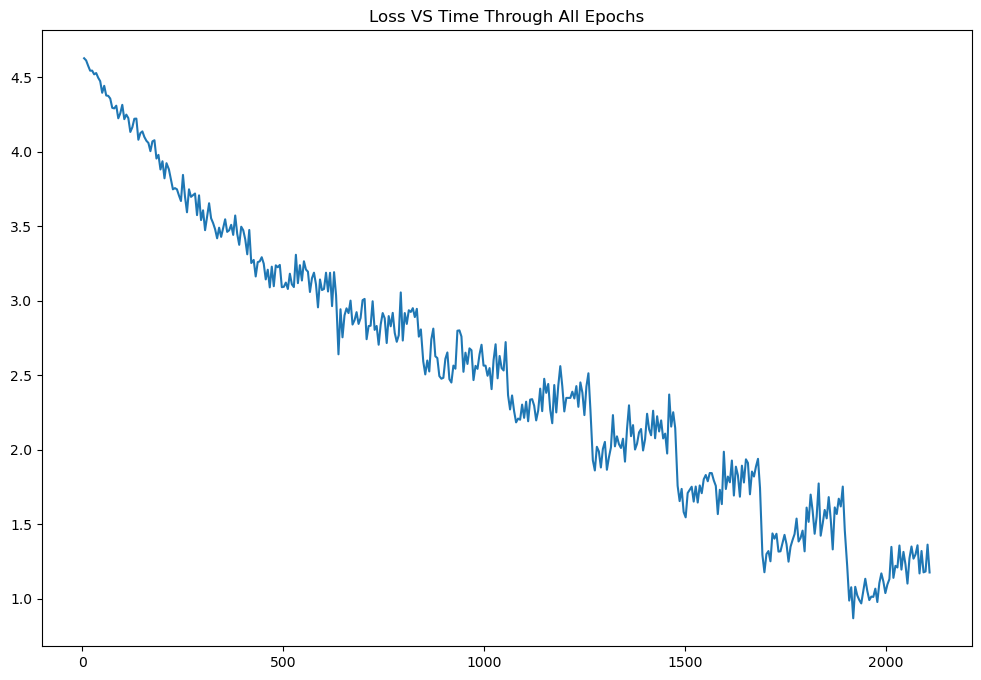

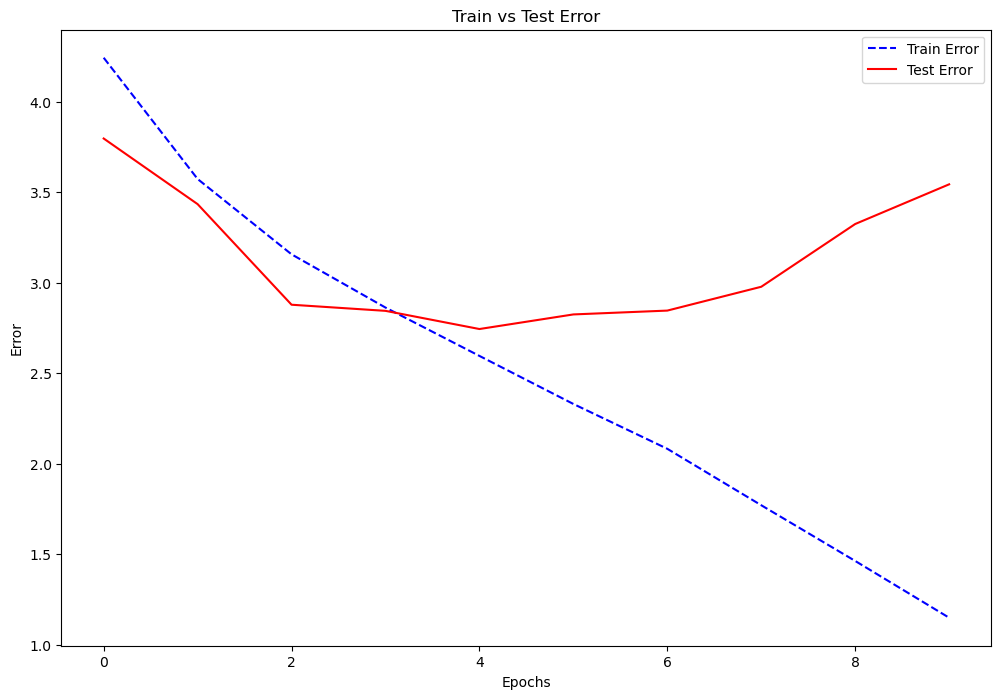

In [8]:
text = """
## Modeling
"""
display(Markdown(text))

inputSize = 224
epoch_num = 10
i = -1
batch_size = 64
lr = 0.005
activation = "Relu"
path = ""


CNNModels = []

text = f"""
### Model Attributes:
- Learning Rate: {lr}
- Input Size: {inputSize}
- Activation Function: {activation}
- Batch Size: {batch_size}
- Epoch Count: {epoch_num}
    """
display(Markdown(text))

model = CNNLES().to(dml)

transform = transformer

metrics = train(model, lr, batch_size, transform, epoch_num, path)

text = """### Results: """
display(Markdown(text))

finalMetrics = testModel(model, False, transform, path)
plotTrainError(metrics[0], metrics[1])
print()
plotTrainTestError(epoch_num, metrics[2], metrics[3])